# Chicago Cab Analysis

Chicago has the second largest cab fleets in the US & according to "rumors" they were facing extinction. According to reports, approximately 40% of the 7000 strong cab fleet had not had a fare for the month of Mar '17. Cabdrivers are struggling to survive in the era dominated by Uber & Lyft & are fighting a losing battle, with 40 percent of all medallions “inactive”. 

In [1]:
from IPython.display import HTML

HTML('<iframe width="650" height="500" src="https://uw-media.usatoday.com/video/embed/27378243?placement=embed" frameborder="0" allowfullscreen></iframe>')

I came across the Chicago cab data through the Chicago Data Portal. Their data was from years 2013-2016 & was of size 40 GB & had around 127 million records. I extracted the data using an API into my Python notebook. Unfortunately, due to system restrictions, I was able to work on only a small sample set of this data (~1%). I analyzed this sample data & my findings resonated with what some articles mentioned about how cab drivers are facing unemployment.


In [2]:
#!pip install sodapy
#!pip install geopy
#!pip install requests
#!pip install --upgrade Pillow
#!pip install --default-timeout=100 future

import pandas as pd
import numpy as np
#import matplotlib as matpp
import matplotlib.pyplot as pp
import matplotlib.colors as clr
from sodapy import Socrata
import time
import datetime
import folium
import calendar
import requests
#from PIL import Image
from IPython.display import Image
from time import sleep

client = Socrata("data.cityofchicago.org", None)

### Taking a sample from the Data

The complete dataset is available at the [Chicago Data Portal](https://data.cityofchicago.org/Transportation/Taxi-Trips/wrvz-psew/data) has more data than what my system could handle. It didn't make sense to download a 40 GB csv file, read it & then analyze it. Hence I accessed the data through the Socrata Open Data API (SODA). System restrictions meant that I could not access the entire dataset. Hence I decided to subset the data. I took a sample of each of the 3 years for sizes 100k, 250k & 500k, structured & aggregated the data & plotted them.

In [3]:
try:
    sample_100k_2016 = client.get("wrvz-psew",limit=100000,
                              where="trip_start_timestamp > '2016-01-01T00:00:00' \
                              AND trip_start_timestamp <= '2016-12-31T00:00:00' AND \
                              pickup_census_tract IS NOT NULL AND \
                              dropoff_census_tract IS NOT NULL")

except requests.exceptions.ConnectionError:
    requests.status_code = "Connection refused"
    

sleep(5)

In [4]:
try:
    sample_250k_2016 = client.get("wrvz-psew",limit=250000,
                              where="trip_start_timestamp > '2016-01-01T00:00:00' \
                              AND trip_start_timestamp <= '2016-12-31T00:00:00' AND \
                              pickup_census_tract IS NOT NULL AND \
                              dropoff_census_tract IS NOT NULL")    

except requests.exceptions.ConnectionError:
    requests.status_code = "Connection refused"
    
sleep(5)

In [5]:
try:
    sample_500k_2016 = client.get("wrvz-psew",limit=500000,
                              where="trip_start_timestamp > '2016-01-01T00:00:00' \
                              AND trip_start_timestamp <= '2016-12-31T00:00:00' AND \
                              pickup_census_tract IS NOT NULL AND \
                              dropoff_census_tract IS NOT NULL")    

except requests.exceptions.ConnectionError:
    requests.status_code = "Connection refused"
    
sleep(5)

In [6]:
# converting to a dataframe

chicago_cab_data_2016_sample_100k = pd.DataFrame.from_records(sample_100k_2016).iloc[:,[14,21]]
chicago_cab_data_2016_sample_250k = pd.DataFrame.from_records(sample_250k_2016).iloc[:,[14,21]]
chicago_cab_data_2016_sample_500k = pd.DataFrame.from_records(sample_500k_2016).iloc[:,[14,21]]

# tagging, appending & restructuring the data

chicago_cab_data_2016_sample_100k['sample']='sample_100k'
chicago_cab_data_2016_sample_250k['sample']='sample_250k'
chicago_cab_data_2016_sample_500k['sample']='sample_500k'

chicago_appended_sample_data=chicago_cab_data_2016_sample_100k.append(chicago_cab_data_2016_sample_250k,ignore_index=True).append(chicago_cab_data_2016_sample_500k,ignore_index=True)

chicago_appended_sample_data["trip_date"]=chicago_appended_sample_data["trip_start_timestamp"].astype(str)
chicago_appended_sample_data["trip_start_time"]=chicago_appended_sample_data["trip_date"].str[-8:]
chicago_appended_sample_data["trip_date"]=chicago_appended_sample_data["trip_date"].str[:10]
chicago_appended_sample_data["trip_year"]=chicago_appended_sample_data["trip_date"].str[:4]
chicago_appended_sample_data["trip_month"]=chicago_appended_sample_data["trip_date"]
chicago_appended_sample_data["trip_month"]=pd.to_datetime(chicago_appended_sample_data["trip_month"])
chicago_appended_sample_data["trip_month"]=chicago_appended_sample_data["trip_month"].apply(lambda x: datetime.datetime.strftime(x,'%b'))


In [7]:
# comparing samples of different sizes for 2016

sample_data_grouped=pd.pivot_table(chicago_appended_sample_data,values='taxi_id',index=('trip_month'),columns=('sample'),fill_value="",margins=2,margins_name="total",aggfunc=[len])
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
sample_data_grouped=sample_data_grouped.reindex(months)
sample_data_grouped = sample_data_grouped.xs('len', axis=1, drop_level=True)
sample_data_grouped

sample,sample_100k,sample_250k,sample_500k,total
trip_month,,,,
Jan,8006.0,20018.0,39836.0,67860.0
Feb,8431.0,21198.0,42061.0,71690.0
Mar,9944.0,24075.0,49360.0,83379.0
Apr,9617.0,24167.0,48314.0,82098.0
May,9500.0,24173.0,47786.0,81459.0
Jun,9733.0,24470.0,49025.0,83228.0
Jul,8867.0,22058.0,44267.0,75192.0
Aug,7913.0,19880.0,39922.0,67715.0
Sep,6749.0,16765.0,33807.0,57321.0


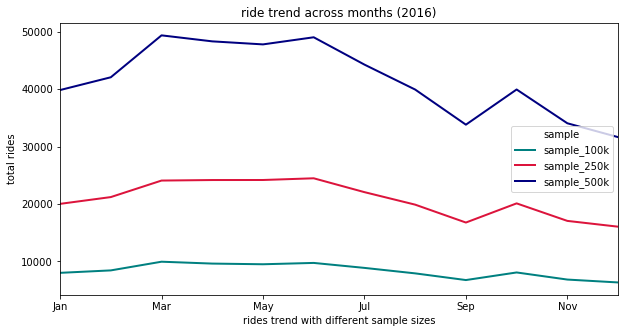

In [8]:
# plotting samples of different sizes for 2016

year_on_year_sample_data_grouped = pd.DataFrame(sample_data_grouped.iloc[0:12,0:3])

color=["TEAL", "CRIMSON", "NAVY"]
year_on_year_sample_data_grouped.plot(figsize=(10,5),color=color,linewidth=2)

pp.xticks(color = 'black')
pp.yticks(color = 'black')

pp.xlabel('rides trend with different sample sizes',color='black')
pp.ylabel('total rides',color='black')

pp.title('ride trend across months (2016)',color='black')

pp.show()

### Extracting samples based on initial analysis

The above graph consists of 3 sample sets of 100k, 250k & 500k for the year 2016. Looking at the samples, it seems rather 
obvious that the samples follow a certain trend & that they can be considered to be an approximate but similar representation of the population.
I opted for the middle value of 250k & proceeded with my analysis for the years 2014-16.

In [9]:
try:
    chicago_cab_data_raw_2016 = client.get("wrvz-psew",limit=250000,where="trip_start_timestamp > '2016-01-01T00:00:00' \
                                        AND trip_start_timestamp <= '2016-12-31T00:00:00'\
                                        AND dropoff_centroid_longitude IS NOT NULL\
                                        AND dropoff_centroid_latitude IS NOT NULL\
                                        AND pickup_centroid_longitude IS NOT NULL\
                                        AND pickup_centroid_latitude IS NOT NULL\
                                        AND company IS NOT NULL")

except requests.exceptions.ConnectionError:
    requests.status_code = "Connection refused"

sleep(5)

try:
    chicago_cab_data_raw_2015 = client.get("wrvz-psew",limit=250000,where="trip_start_timestamp > '2015-01-01T00:00:00' \
                                        AND trip_start_timestamp <= '2015-12-31T00:00:00'\
                                        AND dropoff_centroid_longitude IS NOT NULL \
                                        AND dropoff_centroid_latitude IS NOT NULL \
                                        AND pickup_centroid_longitude IS NOT NULL \
                                        AND pickup_centroid_latitude IS NOT NULL \
                                        AND company IS NOT NULL")

except requests.exceptions.ConnectionError:
    requests.status_code = "Connection refused"
    
sleep(5)

try:
    chicago_cab_data_raw_2014 = client.get("wrvz-psew",limit=250000,where="trip_start_timestamp > '2014-01-01T00:00:00' \
                                        AND trip_start_timestamp <= '2014-12-31T00:00:00' \
                                        AND dropoff_centroid_longitude IS NOT NULL \
                                        AND dropoff_centroid_latitude IS NOT NULL \
                                        AND pickup_centroid_longitude IS NOT NULL \
                                        AND pickup_centroid_latitude IS NOT NULL \
                                        AND company IS NOT NULL")


except requests.exceptions.ConnectionError:
    requests.status_code = "Connection refused"
    
sleep(5)

chicago_cab_data_2016 = pd.DataFrame.from_records(chicago_cab_data_raw_2016)
chicago_cab_data_2015 = pd.DataFrame.from_records(chicago_cab_data_raw_2015)
chicago_cab_data_2014 = pd.DataFrame.from_records(chicago_cab_data_raw_2014)

In [10]:
chicago_3_year_raw_data = pd.concat([chicago_cab_data_2014,chicago_cab_data_2015,chicago_cab_data_2016])
chicago_3_year_raw_data.head(2)

,company,dropoff_census_tract,dropoff_centroid_latitude,dropoff_centroid_location,dropoff_centroid_longitude,dropoff_community_area,extras,fare,payment_type,pickup_census_tract,...,pickup_community_area,taxi_id,tips,tolls,trip_end_timestamp,trip_id,trip_miles,trip_seconds,trip_start_timestamp,trip_total
0,KOAM Taxi Association,17031980000,41.97907082,"{'type': 'Point', 'coordinates': [-87.90303966...",-87.903039661,76,3,36.65,Cash,17031081300,...,8,248103cdd73487ab06014ae0c4bb8dea2cca9402efe076...,0,0,2014-03-04T14:00:00.000,c19412c7da56b16649a666d3a1a884d45d3d4b1f,17.8,1620,2014-03-04T13:30:00.000,39.65
1,Taxi Affiliation Services,NaN,41.857183858,"{'type': 'Point', 'coordinates': [-87.62033462...",-87.620334624,33,0,13.25,Cash,NaN,...,28,55e320fddd3356bfae67e18bb11e168b5d36a87b22a67c...,0,0,2014-11-19T16:45:00.000,c19412f5db9a4d34fcfcce5f3e29e4f031cc54f6,0.3,720,2014-11-19T16:30:00.000,13.25


In [11]:
chicago_3_year_raw_data=chicago_3_year_raw_data.iloc[:,[14,18,0,10,12,11,13,2,4,3,5,21,17,19,20,7,6,15,16,22,8]]
chicago_3_year_raw_data["trip_date"]=pd.to_datetime(chicago_3_year_raw_data["trip_start_timestamp"])
chicago_3_year_raw_data.head(2)

,taxi_id,trip_id,company,pickup_centroid_latitude,pickup_centroid_longitude,pickup_centroid_location,pickup_community_area,dropoff_centroid_latitude,dropoff_centroid_longitude,dropoff_centroid_location,...,trip_end_timestamp,trip_miles,trip_seconds,fare,extras,tips,tolls,trip_total,payment_type,trip_date
0,248103cdd73487ab06014ae0c4bb8dea2cca9402efe076...,c19412c7da56b16649a666d3a1a884d45d3d4b1f,KOAM Taxi Association,41.898331794,-87.620762865,"{'type': 'Point', 'coordinates': [-87.62076286...",8,41.97907082,-87.903039661,"{'type': 'Point', 'coordinates': [-87.90303966...",...,2014-03-04T14:00:00.000,17.8,1620,36.65,3,0,0,39.65,Cash,2014-03-04 13:30:00
1,55e320fddd3356bfae67e18bb11e168b5d36a87b22a67c...,c19412f5db9a4d34fcfcce5f3e29e4f031cc54f6,Taxi Affiliation Services,41.874005383,-87.66351755,"{'type': 'Point', 'coordinates': [-87.66351754...",28,41.857183858,-87.620334624,"{'type': 'Point', 'coordinates': [-87.62033462...",...,2014-11-19T16:45:00.000,0.3,720,13.25,0,0,0,13.25,Cash,2014-11-19 16:30:00


In [12]:
# manipulating trip_date column to extract day & time 

chicago_3_year_raw_data["trip_date"]=chicago_3_year_raw_data["trip_date"].astype(str)
chicago_3_year_raw_data["trip_start_time"]=chicago_3_year_raw_data["trip_date"].str[-8:]
chicago_3_year_raw_data["trip_date"]=chicago_3_year_raw_data["trip_date"].str[:10]
chicago_3_year_raw_data["trip_year"]=chicago_3_year_raw_data["trip_date"].str[:4]
chicago_3_year_raw_data["trip_month"]=chicago_3_year_raw_data["trip_date"]

chicago_3_year_raw_data.head(2)

,taxi_id,trip_id,company,pickup_centroid_latitude,pickup_centroid_longitude,pickup_centroid_location,pickup_community_area,dropoff_centroid_latitude,dropoff_centroid_longitude,dropoff_centroid_location,...,fare,extras,tips,tolls,trip_total,payment_type,trip_date,trip_start_time,trip_year,trip_month
0,248103cdd73487ab06014ae0c4bb8dea2cca9402efe076...,c19412c7da56b16649a666d3a1a884d45d3d4b1f,KOAM Taxi Association,41.898331794,-87.620762865,"{'type': 'Point', 'coordinates': [-87.62076286...",8,41.97907082,-87.903039661,"{'type': 'Point', 'coordinates': [-87.90303966...",...,36.65,3,0,0,39.65,Cash,2014-03-04,13:30:00,2014,2014-03-04
1,55e320fddd3356bfae67e18bb11e168b5d36a87b22a67c...,c19412f5db9a4d34fcfcce5f3e29e4f031cc54f6,Taxi Affiliation Services,41.874005383,-87.66351755,"{'type': 'Point', 'coordinates': [-87.66351754...",28,41.857183858,-87.620334624,"{'type': 'Point', 'coordinates': [-87.62033462...",...,13.25,0,0,0,13.25,Cash,2014-11-19,16:30:00,2014,2014-11-19


In [13]:
# getting month name from month number

chicago_3_year_raw_data["trip_month"]=pd.to_datetime(chicago_3_year_raw_data["trip_month"])
chicago_3_year_raw_data["trip_month"]=chicago_3_year_raw_data["trip_month"].apply(lambda x: datetime.datetime.strftime(x,'%b'))
chicago_3_year_raw_data.tail(2)

,taxi_id,trip_id,company,pickup_centroid_latitude,pickup_centroid_longitude,pickup_centroid_location,pickup_community_area,dropoff_centroid_latitude,dropoff_centroid_longitude,dropoff_centroid_location,...,fare,extras,tips,tolls,trip_total,payment_type,trip_date,trip_start_time,trip_year,trip_month
249998,73680c341d237b6dc8004f3b741eb3618dd82eef947b68...,4f76396a2890f927bcc27b357a38f26a68a335a6,Taxi Affiliation Services,41.93057857,-87.642206313,"{'type': 'Point', 'coordinates': [-87.64220631...",7,41.93057857,-87.642206313,"{'type': 'Point', 'coordinates': [-87.64220631...",...,3.75,0,0,0,3.75,Cash,2016-01-19,10:45:00,2016,Jan
249999,c02da719ff30da52a80533aedcada63fa51c072cc4287d...,4f763a3b20744f7fcc6094ffc5749642eb595683,Dispatch Taxi Affiliation,41.899602111,-87.633308037,"{'type': 'Point', 'coordinates': [-87.63330803...",8,42.009622881,-87.670166857,"{'type': 'Point', 'coordinates': [-87.67016685...",...,24.5,0,4.9,0,29.4,Credit Card,2016-05-11,00:30:00,2016,May


In [14]:
# month on month taxi ride counts across years

chicago_3_year_structured=pd.pivot_table(chicago_3_year_raw_data,values='taxi_id',index=('trip_month'),columns=('trip_year'),fill_value="",margins=2,margins_name="total",aggfunc=[len])
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
chicago_3_year_structured=chicago_3_year_structured.reindex(months)
chicago_3_year_structured

len                           
trip_year      2014     2015     2016    total
trip_month                                    
Jan         18459.0  20295.0  20940.0  59694.0
Feb         19100.0  20759.0  21606.0  61465.0
Mar         22253.0  22914.0  24369.0  69536.0
Apr         21931.0  21621.0  24514.0  68066.0
May         23321.0  23790.0  24514.0  71625.0
Jun         22739.0  22471.0  24034.0  69244.0
Jul         21362.0  21841.0  21875.0  65078.0
Aug         21386.0  20651.0  19984.0  62021.0
Sep         19998.0  19720.0  18620.0  58338.0
Oct         21178.0  20657.0  19129.0  60964.0
Nov         19496.0  17956.0  15974.0  53426.0
Dec         18777.0  17325.0  14441.0  50543.0

In [15]:
# dropping level for ease

chicago_3_year_structured = chicago_3_year_structured.xs('len', axis=1, drop_level=True)
chicago_3_year_structured

trip_year,2014,2015,2016,total
trip_month,,,,
Jan,18459.0,20295.0,20940.0,59694.0
Feb,19100.0,20759.0,21606.0,61465.0
Mar,22253.0,22914.0,24369.0,69536.0
Apr,21931.0,21621.0,24514.0,68066.0
May,23321.0,23790.0,24514.0,71625.0
Jun,22739.0,22471.0,24034.0,69244.0
Jul,21362.0,21841.0,21875.0,65078.0
Aug,21386.0,20651.0,19984.0,62021.0
Sep,19998.0,19720.0,18620.0,58338.0


In [16]:
chicago_3_year_structured = pd.DataFrame(chicago_3_year_structured.iloc[0:12,0:3])
chicago_3_year_structured

trip_year,2014,2015,2016
trip_month,,,
Jan,18459.0,20295.0,20940.0
Feb,19100.0,20759.0,21606.0
Mar,22253.0,22914.0,24369.0
Apr,21931.0,21621.0,24514.0
May,23321.0,23790.0,24514.0
Jun,22739.0,22471.0,24034.0
Jul,21362.0,21841.0,21875.0
Aug,21386.0,20651.0,19984.0
Sep,19998.0,19720.0,18620.0


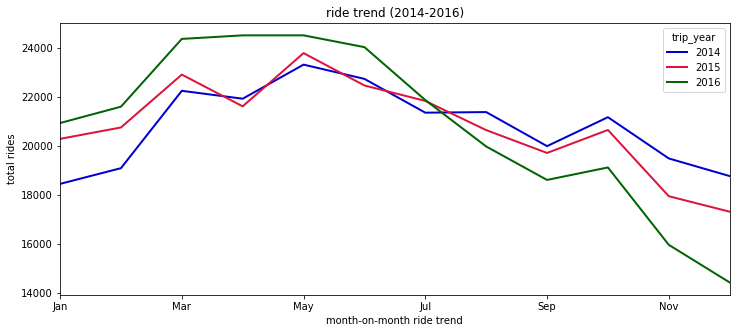

In [17]:
# plotting month on month total ride count across years

color=["MEDIUMBLUE", "CRIMSON", "DARKGREEN"]

chicago_3_year_structured.plot(figsize=(12,5),color=color,linewidth=2)

#ax.set_xticks(chicago_3_year_structured['trip_month'],minor=True)
pp.xlabel('month-on-month ride trend',color='black')

pp.xticks(color = 'black')
pp.yticks(color = 'black')
pp.ylabel('total rides',color='black')
pp.title('ride trend (2014-2016)',color='black')
pp.xticks(rotation='horizontal')
pp.show()

As we can see, the number of rides go up in each of the 3 years as each year begins. However, as the second half of the year begins, the ride numbers go down drastically.

### Are Lyft & Uber affecting the taxi business ?

I came across quite a few articles stating that cab drivers all across the US are being driven out of business thanks to Uber & Lyft. Quite a few drivers have even filed for bankruptcy. With the data at hand, I then looked at the count of taxis to have picked up atleast a ride per day in Chicago & aggregated it.

            active taxis
year_month              
2014 - Jan          2458
2014 - Feb          2533
2014 - Mar          2601
2014 - Apr          2694
2014 - May          2688
2014 - Jun          2617
2014 - Jul          2673
2014 - Aug          2620
2014 - Sep          2589
2014 - Oct          2583
2014 - Nov          2572
2014 - Dec          2541
2015 - Jan          2493
2015 - Feb          2516
2015 - Mar          2541
2015 - Apr          2563
2015 - May          2605
2015 - Jun          2613
2015 - Jul          2598
2015 - Aug          2524
2015 - Sep          2490
2015 - Oct          2530
2015 - Nov          2492
2015 - Dec          2443
2016 - Jan          2258
2016 - Feb          2310
2016 - Mar          2345
2016 - Apr          2358
2016 - May          2333
2016 - Jun          2307
2016 - Jul          2243
2016 - Aug          2175
2016 - Sep          2103
2016 - Oct          1974
2016 - Nov          1873
2016 - Dec          1760


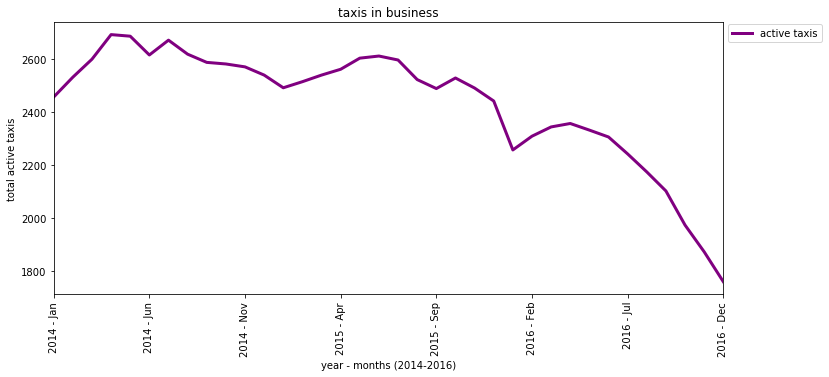

In [18]:
taxis_in_business=chicago_3_year_raw_data.groupby(["trip_year","trip_month"]).agg({"taxi_id": pd.Series.nunique})
taxis_in_business=taxis_in_business.reset_index()

taxis_in_business['year_month'] = taxis_in_business["trip_year"] +" - "+taxis_in_business["trip_month"]
taxis_in_business=taxis_in_business.iloc[:,2:]

year_month=['2014 - Jan','2014 - Feb','2014 - Mar','2014 - Apr','2014 - May','2014 - Jun','2014 - Jul','2014 - Aug','2014 - Sep','2014 - Oct','2014 - Nov','2014 - Dec','2015 - Jan','2015 - Feb','2015 - Mar','2015 - Apr','2015 - May','2015 - Jun','2015 - Jul','2015 - Aug','2015 - Sep','2015 - Oct','2015 - Nov','2015 - Dec','2016 - Jan','2016 - Feb','2016 - Mar','2016 - Apr','2016 - May','2016 - Jun','2016 - Jul','2016 - Aug','2016 - Sep','2016 - Oct','2016 - Nov','2016 - Dec']

taxis_in_business=taxis_in_business.set_index('year_month')
taxis_in_business=taxis_in_business.reindex(year_month)

taxis_in_business = taxis_in_business.rename(columns={'taxi_id':'active taxis'})

taxis_in_business.plot(figsize=(12,5),color = 'purple',linewidth = 3,kind="line")

pp.xlabel('year - months (2014-2016)',color='black')
pp.xticks(color = 'black')
pp.yticks(color = 'black')
pp.ylabel('total active taxis',color='black')
pp.title('taxis in business',color='black')
pp.xticks(rotation='vertical')
pp.legend(loc='center left', bbox_to_anchor=(1,.96))
print(taxis_in_business)
pp.show()


As we can see, the unique count of taxi id has gone down from ~2500 to ~1800 over a period of 3 years. Which is almost a 70% decrease - which resonates with the below mentioned article.

[Number of Chicago taxi drivers hits 10-year low as ride-share companies take off - Chicago Tribune (Dec 16, 2017)](http://www.chicagotribune.com/news/ct-chicago-taxi-driver-decline-met-20161214-story.html)

In [19]:
Image(url= "https://www.gannett-cdn.com/usatoday/editorial/graphics/2017/06/060517-chicago-taxi-foreclosures_online.png")

### Can we find any trends in the data ?

Curious to look at whether I could find any trends in the data, I then plotted a time series graph across my entire sample data & the results were quite interesting.

In [20]:
# day on day total rides across 2014-16

day_on_day_trend_2016 = chicago_3_year_raw_data[(chicago_3_year_raw_data["trip_date"] >= '2014-01-01') & (chicago_3_year_raw_data["trip_date"] <= '2016-12-31')]
day_on_day_trend_2016 = day_on_day_trend_2016.rename(columns={'trip_id':'count of trips'})
ax = pd.pivot_table(day_on_day_trend_2016, values='count of trips', columns=['trip_date'], fill_value="",aggfunc=[len]).T
ax = ax.xs('len', axis=0, drop_level=True)

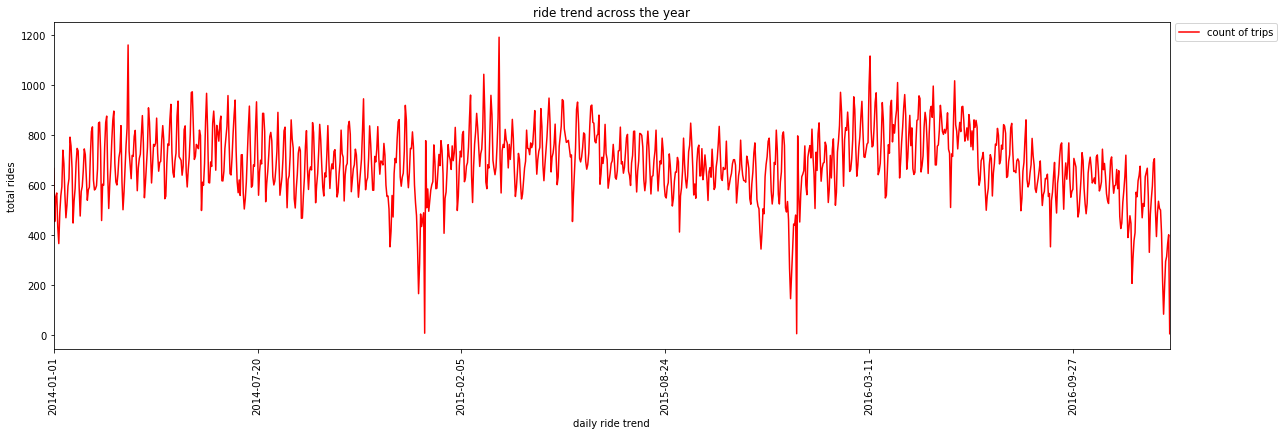

In [21]:
ax.plot(figsize=(20,6),color='red')
pp.xlabel('daily ride trend',color='black')
pp.xticks(color = 'black')
pp.yticks(color = 'black')
pp.ylabel('total rides',color='black')
pp.title('ride trend across the year',color='black')
pp.xticks(rotation='vertical')
pp.legend(loc='center left', bbox_to_anchor=(1,.97))
pp.show()

As we can see in the above image, there are distinct peaks & troughs across the entire timeline. However, for each year, there is a distinct peak at around March. To get a better idea of the data, I aggregated the data on "total rides on a per day basis", sorted the data & looked at the top 10 days with most number of cab rides. Also, using the date, I extracted the days corresponding to these dates.

In [22]:
# top 10 days with most cab rides (2014-16)

chicago_3_year_raw_data['count']=1
reqd_cols=chicago_3_year_raw_data.pivot_table(columns="trip_date",aggfunc=sum).T.reset_index().sort_values(by='count',ascending=False)
reqd_cols['trip_date']=reqd_cols['trip_date'].astype('datetime64[ns]')
reqd_cols['day']=reqd_cols['trip_date'].dt.strftime('%A')
reqd_cols['year']=reqd_cols['trip_date'].dt.strftime('%Y')
reqd_cols.head(10)

,trip_date,count,day,year
437,2015-03-14,1190,Saturday,2015
73,2014-03-15,1159,Saturday,2014
801,2016-03-12,1115,Saturday,2016
422,2015-02-27,1042,Friday,2015
884,2016-06-03,1016,Friday,2016
828,2016-04-08,1009,Friday,2016
800,2016-03-11,995,Friday,2016
863,2016-05-13,995,Friday,2016
136,2014-05-17,972,Saturday,2014
772,2016-02-12,970,Friday,2016


One interesting observation was that in the top ten days with most cabs hired, each and every day was either on a Friday or a Saturday. So one hypothesis that I could come up with is that the weekend, the Chicagoans prefer to take cabs over the weekend more than the weekday. However, this would need more clarity. So, I plotted the cab hire counts across the entire week for each of the 3 years. 

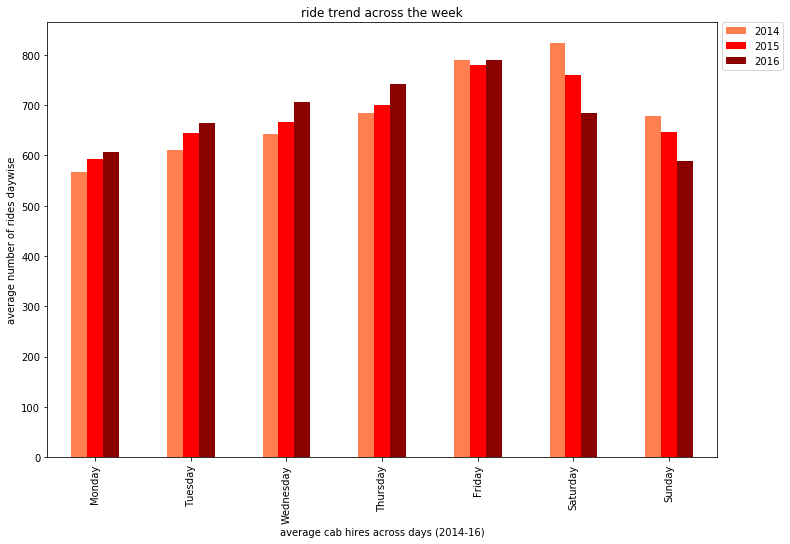

In [23]:
# day wise cabs hires

day_wise_cab_rides=reqd_cols.pivot_table(index="day",columns="year",values="count",aggfunc=np.mean)
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday','Sunday']
day_wise_cab_rides=day_wise_cab_rides.reindex(days)
day_wise_cab_rides

color = ["coral","red","darkred"]
day_wise_cab_rides.plot(kind="bar",figsize=(12,8),legend=False,color=color)
pp.xlabel('average cab hires across days (2014-16)',color='black')
pp.xticks(color = 'black')
pp.yticks(color = 'black')
pp.ylabel('average number of rides daywise',color='black')
pp.title('ride trend across the week',color='black')
pp.xticks(rotation='vertical')
pp.legend(loc='center left', bbox_to_anchor=(1,.945))
pp.show()

As evident from the graph above, my hypothesis held true. Weekday rides are low as compared to the weekend & as the weekend approaches, the ride count keeps increasing.

### Average Ride Cost vs Average Trip Duration across the years

I then wanted to see if there has been a significant change in average ride costs or average ride times across the years.

In [24]:
# average month on month ride cost (2014-16) 

chicago_3_year_raw_data1=chicago_3_year_raw_data.dropna()
chicago_3_year_raw_data1[["fare","tips","trip_total","extras","tolls","trip_miles","trip_seconds"]]=chicago_3_year_raw_data1[["fare","tips","trip_total","extras","tolls","trip_miles","trip_seconds"]].apply(pd.to_numeric)

chicago_3_year_structured_money=pd.pivot_table(chicago_3_year_raw_data1,values=('trip_total'),index=('trip_month'),columns=('trip_year'),margins=2,margins_name="total",aggfunc=[np.average])
chicago_3_year_structured_money=chicago_3_year_structured_money.round(2)
chicago_3_year_structured_money=chicago_3_year_structured_money.iloc[:12,:3]
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
chicago_3_year_structured_money=chicago_3_year_structured_money.reindex(months)
chicago_3_year_structured_money.columns = chicago_3_year_structured_money.columns.set_levels(['avg ride cost (in USD)'], level=0)
chicago_3_year_structured_money

C:\Anaconda3\lib\site-packages\pandas\core\frame.py:2450: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


avg ride cost (in USD)              
trip_year                    2014   2015   2016
trip_month                                     
Jan                         11.63  12.35  13.88
Feb                         11.90  12.44  14.08
Mar                         12.62  13.24  14.85
Apr                         12.61  13.64  15.61
May                         13.88  14.07  15.94
Jun                         13.41  14.23  15.71
Jul                         13.62  13.91  15.39
Aug                         13.00  13.69  15.34
Sep                         13.38  13.91  15.49
Oct                         13.60  14.23  15.79
Nov                         13.23  13.80  15.48
Dec                         12.41  12.74  13.66

In [25]:
chicago_3_year_structured_money_1 = chicago_3_year_structured_money.xs('avg ride cost (in USD)', axis=1, drop_level=True)
chicago_3_year_structured_money_1 = chicago_3_year_structured_money_1.unstack()

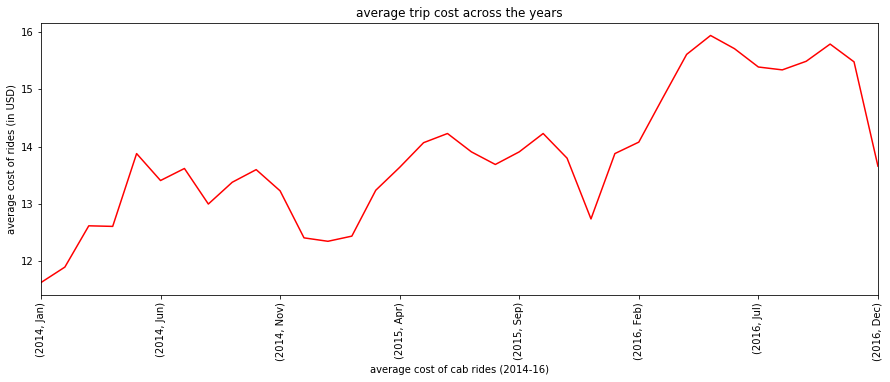

In [26]:
chicago_3_year_structured_money_1.plot(figsize=(15,5),color='red')

pp.xlabel('average cost of cab rides (2014-16)',color='black')
pp.xticks(color = 'black')
pp.yticks(color = 'black')
pp.ylabel('average cost of rides (in USD)',color='black')
pp.title('average trip cost across the years',color='black')
pp.xticks(rotation='vertical')

pp.show()

As we can see, the average ride cost at the start of the year is slightly less than \$12. However, just before 2016 ended, the average ride cost was around \$16 before reducing to around \$12. 

In [27]:
# average month on month trip duration in minutes (2014-16)

chicago_3_year_structured_duration=pd.pivot_table(chicago_3_year_raw_data1,values=('trip_seconds'),index=('trip_month'),columns=('trip_year'),margins=2,margins_name="total",aggfunc=[np.average])
chicago_3_year_structured_duration=(chicago_3_year_structured_duration/60).round(2)
chicago_3_year_structured_duration=chicago_3_year_structured_duration.iloc[:12,:3]
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
chicago_3_year_structured_duration=chicago_3_year_structured_duration.reindex(months)
chicago_3_year_structured_duration.columns = chicago_3_year_structured_duration.columns.set_levels(['avg trip time (in minutes)'], level=0)
chicago_3_year_structured_duration


avg trip time (in minutes)              
trip_year                        2014   2015   2016
trip_month                                         
Jan                             11.47  11.49  11.18
Feb                             11.74  11.96  11.56
Mar                             12.01  12.33  12.28
Apr                             11.95  12.58  12.86
May                             12.94  13.19  13.51
Jun                             12.92  13.81  13.92
Jul                             12.78  13.30  13.46
Aug                             12.53  13.01  13.17
Sep                             12.96  13.59  13.54
Oct                             13.06  13.53  13.74
Nov                             12.49  13.03  13.48
Dec                             11.81  11.90  12.05

In [28]:
chicago_3_year_structured_duration_1 = chicago_3_year_structured_duration.xs('avg trip time (in minutes)', axis=1,drop_level=True)
chicago_3_year_structured_duration_1 =chicago_3_year_structured_duration_1.unstack()

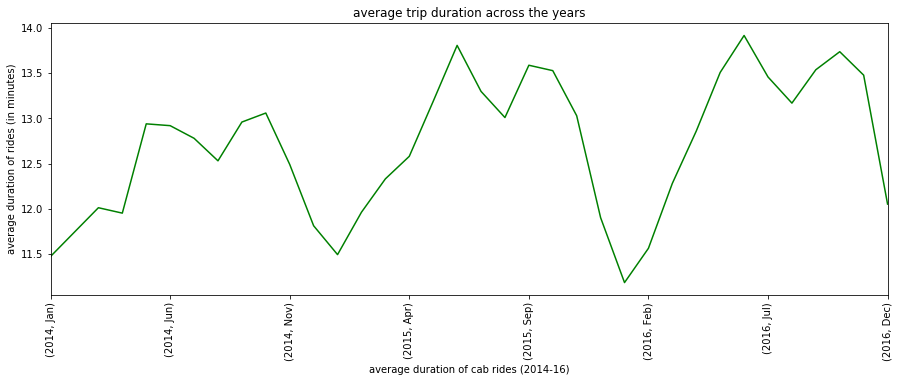

In [29]:
chicago_3_year_structured_duration_1.plot(figsize=(15,5),color='green')

pp.xlabel('average duration of cab rides (2014-16)',color='black')
pp.xticks(color = 'black')
pp.yticks(color = 'black')
pp.ylabel('average duration of rides (in minutes)',color='black')
pp.title('average trip duration across the years',color='black')
pp.xticks(rotation='vertical')

pp.show()

As we can see, the average trip duration at the start of the year is around 11.5 minutes. However, just before 2016 ended, the average ride cost was around 13 minutes.

The above 2 data points do not make much sense when looked at individually. So, I merged these 2 datasets & plotted the data overlapped data points.

In [30]:
# average month on month across years ride cost vs trip duration

compare_trip_cost_and_duration = [chicago_3_year_structured_money, chicago_3_year_structured_duration]
compare_trip_cost_and_duration_1 = pd.concat(compare_trip_cost_and_duration, axis=1)
compare_trip_cost_and_duration_1

avg ride cost (in USD)               avg trip time (in minutes)  \
trip_year                    2014   2015   2016                       2014   
trip_month                                                                   
Jan                         11.63  12.35  13.88                      11.47   
Feb                         11.90  12.44  14.08                      11.74   
Mar                         12.62  13.24  14.85                      12.01   
Apr                         12.61  13.64  15.61                      11.95   
May                         13.88  14.07  15.94                      12.94   
Jun                         13.41  14.23  15.71                      12.92   
Jul                         13.62  13.91  15.39                      12.78   
Aug                         13.00  13.69  15.34                      12.53   
Sep                         13.38  13.91  15.49                      12.96   
Oct                         13.60  14.23  15.79                      13.06   
Nov                         13.23  13.80  15.48                      12.49   
Dec                         12.41  12.74  13.66                      11.81   

                          
trip_year    2015   2016  
trip_month                
Jan         11.49  11.18  
Feb         11.96  11.56  
Mar         12.33  12.28  
Apr         12.58  12.86  
May         13.19  13.51  
Jun         13.81  13.92  
Jul         13.30  13.46  
Aug         13.01  13.17  
Sep         13.59  13.54  
Oct         13.53  13.74  
Nov         13.03  13.48  
Dec         11.90  12.05

In [31]:
# restructuring data for plotting purposes

compare_trip_cost_and_duration_1=compare_trip_cost_and_duration_1.stack()
compare_trip_cost_and_duration_1=compare_trip_cost_and_duration_1.reset_index()

compare_trip_cost_and_duration_1['year_month'] = compare_trip_cost_and_duration_1["trip_year"] +" - "+compare_trip_cost_and_duration_1["trip_month"]
compare_trip_cost_and_duration_1=compare_trip_cost_and_duration_1.iloc[:,2:]

compare_trip_cost_and_duration_1=compare_trip_cost_and_duration_1.set_index('year_month')
compare_trip_cost_and_duration_1.head(5)

,avg ride cost (in USD),avg trip time (in minutes)
year_month,,
2014 - Jan,11.63,11.47
2015 - Jan,12.35,11.49
2016 - Jan,13.88,11.18
2014 - Feb,11.90,11.74
2015 - Feb,12.44,11.96


In [32]:
year_month=['2014 - Jan','2014 - Feb','2014 - Mar','2014 - Apr','2014 - May','2014 - Jun','2014 - Jul','2014 - Aug','2014 - Sep','2014 - Oct','2014 - Nov','2014 - Dec','2015 - Jan','2015 - Feb','2015 - Mar','2015 - Apr','2015 - May','2015 - Jun','2015 - Jul','2015 - Aug','2015 - Sep','2015 - Oct','2015 - Nov','2015 - Dec','2016 - Jan','2016 - Feb','2016 - Mar','2016 - Apr','2016 - May','2016 - Jun','2016 - Jul','2016 - Aug','2016 - Sep','2016 - Oct','2016 - Nov','2016 - Dec']
compare_trip_cost_and_duration_1=compare_trip_cost_and_duration_1.reindex(year_month)
compare_trip_cost_and_duration_1.head(5)

,avg ride cost (in USD),avg trip time (in minutes)
year_month,,
2014 - Jan,11.63,11.47
2014 - Feb,11.90,11.74
2014 - Mar,12.62,12.01
2014 - Apr,12.61,11.95
2014 - May,13.88,12.94


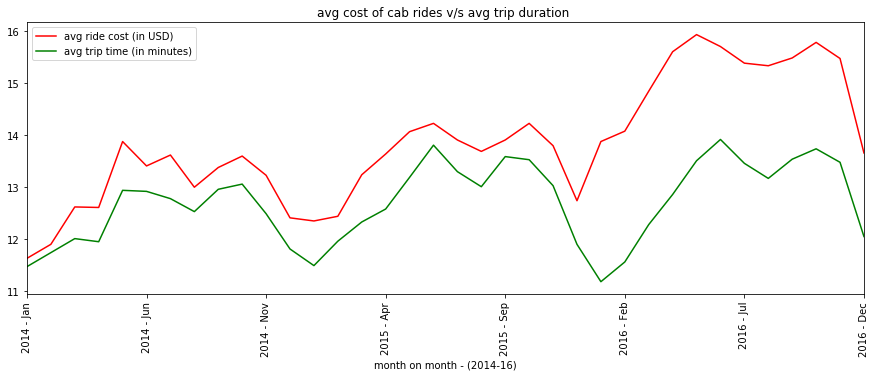

In [33]:
compare_trip_cost_and_duration_1.plot(figsize=(15,5),color=['RED','GREEN'])

pp.xlabel('month on month - (2014-16)',color='black')
pp.xticks(color = 'black')
pp.yticks(color = 'black')
pp.title('avg cost of cab rides v/s avg trip duration ',color='black')
pp.xticks(rotation='vertical')

pp.show()

As we can see initially, the 2 variables, average cab ride times & average cost of taxi hires go hand in hand. However, as the year 2016 begins, even though average ride time has remained a more or less a consistent value, the average cab ride cost has increased tremendously!

### Payment Types Trends

Then to check if there was any particluar cab ride fare method that was more common than others, I analysed the "payment_type" field of this dataset.

In [34]:
# credit card payments vs cash payments

chicago_3_year_raw_data
type_of_payment = chicago_3_year_raw_data[["trip_id","payment_type","trip_year","trip_month"]]
type_of_payment_grouped = type_of_payment.pivot_table(index="trip_month",columns=["trip_year","payment_type"],values="trip_id",aggfunc=np.count_nonzero,margins=0) 

months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
type_of_payment_grouped=type_of_payment_grouped.reindex(months)
type_of_payment_grouped=type_of_payment_grouped.drop(['Dispute','No Charge','Unknown'],axis=1,level=1)

In [35]:
type_of_payment_grouped

trip_year      2014               2015               2016            
payment_type   Cash Credit Card   Cash Credit Card   Cash Credit Card
trip_month                                                           
Jan           13325        4901  12887        7205  11968        8744
Feb           13442        5435  13105        7445  11951        9389
Mar           15648        6362  13778        8861  13222       10855
Apr           15053        6641  12822        8603  13012       11214
May           15759        7355  14025        9496  13116       11117
Jun           15057        7478  13031        9220  12793       10969
Jul           14389        6800  13432        8213  12294        9371
Aug           14347        6899  12515        7933  11082        8683
Sep           12905        6893  11532        7967  10193        8235
Oct           13336        7628  11609        8831  10194        8694
Nov           12397        6901  10121        7639   8390        7353
Dec           12489        6099  10232        6925   8053        6178

In [36]:
type_of_payment_percent = round(100*type_of_payment_grouped.div(type_of_payment_grouped.sum(axis=1, level=0), level=0),1)
type_of_payment_percent_1 = type_of_payment_percent.astype(str)+"%"
type_of_payment_percent_1

trip_year      2014               2015               2016            
payment_type   Cash Credit Card   Cash Credit Card   Cash Credit Card
trip_month                                                           
Jan           73.1%       26.9%  64.1%       35.9%  57.8%       42.2%
Feb           71.2%       28.8%  63.8%       36.2%  56.0%       44.0%
Mar           71.1%       28.9%  60.9%       39.1%  54.9%       45.1%
Apr           69.4%       30.6%  59.8%       40.2%  53.7%       46.3%
May           68.2%       31.8%  59.6%       40.4%  54.1%       45.9%
Jun           66.8%       33.2%  58.6%       41.4%  53.8%       46.2%
Jul           67.9%       32.1%  62.1%       37.9%  56.7%       43.3%
Aug           67.5%       32.5%  61.2%       38.8%  56.1%       43.9%
Sep           65.2%       34.8%  59.1%       40.9%  55.3%       44.7%
Oct           63.6%       36.4%  56.8%       43.2%  54.0%       46.0%
Nov           64.2%       35.8%  57.0%       43.0%  53.3%       46.7%
Dec           67.2%       32.8%  59.6%       40.4%  56.6%       43.4%

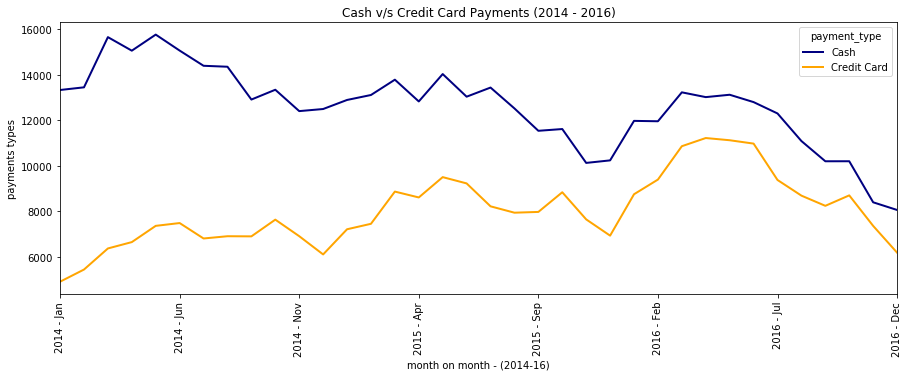

In [37]:
type_of_payment_grouped_yoy = type_of_payment.pivot_table(index=["trip_year","trip_month"],columns="payment_type",values="trip_id",aggfunc=np.count_nonzero,margins=0) 
type_of_payment_grouped_yoy=type_of_payment_grouped_yoy.iloc[:,:2]
type_of_payment_grouped_yoy=type_of_payment_grouped_yoy.reset_index()
type_of_payment_grouped_yoy['year_month'] = type_of_payment_grouped_yoy["trip_year"] +" - "+type_of_payment_grouped_yoy["trip_month"]
type_of_payment_grouped_yoy=type_of_payment_grouped_yoy.iloc[:,2:]
type_of_payment_grouped_yoy=type_of_payment_grouped_yoy.set_index('year_month')
year_month=['2014 - Jan','2014 - Feb','2014 - Mar','2014 - Apr','2014 - May','2014 - Jun','2014 - Jul','2014 - Aug','2014 - Sep','2014 - Oct','2014 - Nov','2014 - Dec','2015 - Jan','2015 - Feb','2015 - Mar','2015 - Apr','2015 - May','2015 - Jun','2015 - Jul','2015 - Aug','2015 - Sep','2015 - Oct','2015 - Nov','2015 - Dec','2016 - Jan','2016 - Feb','2016 - Mar','2016 - Apr','2016 - May','2016 - Jun','2016 - Jul','2016 - Aug','2016 - Sep','2016 - Oct','2016 - Nov','2016 - Dec']
type_of_payment_grouped_yoy=type_of_payment_grouped_yoy.reindex(year_month)

type_of_payment_grouped_yoy.plot(figsize=(15,5),color=['navy','orange'],linewidth=2)

pp.xlabel('month on month - (2014-16)',color='black')
pp.ylabel('payments types',color='black')

pp.xticks(color = 'black')
pp.yticks(color = 'black')
pp.xticks(rotation='vertical')

pp.title("Cash v/s Credit Card Payments (2014 - 2016)",color ='black')

pp.show()

At the start of 2014, Cash payments contributed to approximately 73%. However, over time of 3 years, we can see that payment through cash reduced to approximately 56% & payment through Credit card increased in the same time period.

### Favorite Pick-up/ Drop-off spots across Chicago

I wanted to have a look at the most common pickup/drop-off spots for cab drivers. In order to do that I had to manipulate the latitudes and longitudes into formats that would be acceptable by the package geopy. I passed the latitude, longitude values through the geopy function & reverse geolocated the addresses of the pickup/ drop-offs on a map using the folium package. Basically, I created a function that enables the user to look up any number of top pickup/drop off places in Chicago. The size of the bubble indicates the count of the number of pickup/ drop offs.

In [38]:
# manipulating data for plotting pick up & drop offs on a map

chicago_3_year_raw_data['pick_up_lat_lon']=chicago_3_year_raw_data[['pickup_centroid_latitude','pickup_centroid_longitude']].apply(tuple,axis=1)
chicago_3_year_raw_data['drop_off_lat_lon']=chicago_3_year_raw_data[['dropoff_centroid_latitude','dropoff_centroid_longitude']].apply(tuple,axis=1)
chicago_3_year_raw_data.dtypes

taxi_id                       object
trip_id                       object
company                       object
pickup_centroid_latitude      object
pickup_centroid_longitude     object
pickup_centroid_location      object
pickup_community_area         object
dropoff_centroid_latitude     object
dropoff_centroid_longitude    object
dropoff_centroid_location     object
dropoff_community_area        object
trip_start_timestamp          object
trip_end_timestamp            object
trip_miles                    object
trip_seconds                  object
fare                          object
extras                        object
tips                          object
tolls                         object
trip_total                    object
payment_type                  object
trip_date                     object
trip_start_time               object
trip_year                     object
trip_month                    object
count                          int64
pick_up_lat_lon               object
d

In [39]:
top_drop_off_spots=pd.crosstab(index=(chicago_3_year_raw_data['drop_off_lat_lon']),columns='count')
top_drop_off_spots=top_drop_off_spots.sort_values(ascending=False,by='count').head(10)
top_drop_off_spots=top_drop_off_spots.reset_index()
top_drop_off_spots[['lat','lon']]=top_drop_off_spots['drop_off_lat_lon'].apply(pd.Series)

# formatting lat & lon for drop offs

top_pick_up_spots=pd.crosstab(index=(chicago_3_year_raw_data['pick_up_lat_lon']),columns='count')
top_pick_up_spots=top_pick_up_spots.sort_values(ascending=False,by='count').head(10)
top_pick_up_spots=top_pick_up_spots.reset_index()
top_pick_up_spots[['lat','lon']]=top_pick_up_spots['pick_up_lat_lon'].apply(pd.Series)


In [40]:
# !pip install --upgrade geopy

# from geopy.geocoders import Nominatim
# geolocator = Nominatim()

# ##################################################################

# temp fix for Nomatim issue
from geopy.geocoders import Nominatim
from urllib.request import Request

def get_geolocator():
    geolocator = Nominatim()

    requester = geolocator.urlopen

    def requester_hack(req, **kwargs):
        req = Request(url=req, headers=geolocator.headers)
        return requester(req, **kwargs)

    geolocator.urlopen = requester_hack

    return geolocator

In [41]:
# Top areas where passengers are picked up  

def top_pickup(trip_year,counter):
    
    top_pick_up_spots=pd.pivot_table(data=chicago_3_year_raw_data,values='taxi_id',index=[('pick_up_lat_lon')],columns=['trip_year'],aggfunc='count',fill_value=0,margins=2,margins_name="total")
    top_pick_up_spots=top_pick_up_spots.loc[:,trip_year]
    top_pick_up_spots=pd.DataFrame(top_pick_up_spots)
    top_pick_up_spots=top_pick_up_spots.drop('total').sort_values(by=trip_year,ascending=False).head(counter)
    top_pick_up_spots=top_pick_up_spots.reset_index()
    top_pick_up_spots[['lat','lon']]=top_pick_up_spots['pick_up_lat_lon'].apply(pd.Series)
    top_pick_up_spots_1=pd.DataFrame(top_pick_up_spots.drop('pick_up_lat_lon',axis=1))
    top_pick_up_spots_1=top_pick_up_spots.iloc[:,1:]
    top_pick_up_spots_1
#    top_pick_up_spots_1['address'] = top_pick_up_spots_1.apply(lambda row: geolocator.reverse((row['lat'], row['lon'])), axis=1)
   
    top_pick_up_spots_1['address'] = top_pick_up_spots_1.apply(lambda row: get_geolocator().reverse((row['lat'],row['lon'])),axis=1)
#     location = geolocator.geocode(address, timeout=10, exactly_one=False)
    
    top_pick_up_spots_1['lat']=pd.DataFrame.convert_objects(top_pick_up_spots_1['lat'],convert_numeric=True)
    top_pick_up_spots_1['lon']=pd.DataFrame.convert_objects(top_pick_up_spots_1['lon'],convert_numeric=True)
    top_pick_up_spots_1['address']=top_pick_up_spots_1['address'].astype(str)
  
    lat=top_pick_up_spots_1['lat']
    lon=top_pick_up_spots_1['lon']
  
    lat_mean = top_pick_up_spots_1['lat'].mean()
    lon_mean = top_pick_up_spots_1['lon'].mean()
  
    locationlist = top_pick_up_spots_1[["lat","lon"]].values.tolist()
    labels = top_pick_up_spots_1["address"].values.tolist()
    chimap = folium.Map([lat_mean,lon_mean], zoom_start=12)
    folium.TileLayer('cartodbpositron').add_to(chimap)
    pick_up_size=top_pick_up_spots_1.iloc[:,0]    
      
    for i in range(len(locationlist)):
        popup = folium.Popup(str(labels[i]) +" -> (total pick ups  = "+ str(int(pick_up_size[i])) + ")", parse_html=True)
        icon=folium.Icon(color='red')
        folium.CircleMarker(locationlist[i], popup=popup, icon = icon,color='green',fill_color='green',radius = pick_up_size[i]/1000,fill=True).add_to(chimap)
    return(chimap)
    return(top_pick_up_spots_1)

In [42]:
top_pickup('2015',10)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


In [43]:
# Top areas to where passengers are dropped off 

def top_dropoff(trip_year,counter):
        
    top_drop_off_spots=pd.pivot_table(data=chicago_3_year_raw_data,values='taxi_id',index=[('drop_off_lat_lon')],columns=['trip_year'],aggfunc='count',fill_value=0,margins=2,margins_name="total")
    top_drop_off_spots=top_drop_off_spots.loc[:,trip_year]
    top_drop_off_spots=pd.DataFrame(top_drop_off_spots)
    top_drop_off_spots=top_drop_off_spots.drop('total').sort_values(by=trip_year,ascending=False).head(counter)
    top_drop_off_spots=top_drop_off_spots.reset_index()
    top_drop_off_spots[['lat','lon']]=top_drop_off_spots['drop_off_lat_lon'].apply(pd.Series)
    top_drop_off_spots_1=pd.DataFrame(top_drop_off_spots.drop('drop_off_lat_lon',axis=1))
    top_drop_off_spots_1=top_drop_off_spots.iloc[:,1:]

#    top_drop_off_spots_1['address'] = top_drop_off_spots_1.apply(lambda row: geolocator.reverse((row['lat'], row['lon'])), axis=1)

    top_drop_off_spots_1['address'] = top_drop_off_spots_1.apply(lambda row: get_geolocator().reverse((row['lat'],row['lon'])),axis=1)
    top_drop_off_spots_1['lat']=pd.DataFrame.convert_objects(top_drop_off_spots_1['lat'],convert_numeric=True)
    top_drop_off_spots_1['lon']=pd.DataFrame.convert_objects(top_drop_off_spots_1['lon'],convert_numeric=True)
    top_drop_off_spots_1['address']=top_drop_off_spots_1['address'].astype(str)
    
    lat=top_drop_off_spots_1['lat']
    lon=top_drop_off_spots_1['lon']
    
    lat_mean = top_drop_off_spots_1['lat'].mean()
    lon_mean = top_drop_off_spots_1['lon'].mean()
    
    locationlist = top_drop_off_spots_1[["lat","lon"]].values.tolist()
    labels = top_drop_off_spots_1["address"].values.tolist()

    chimap = folium.Map([lat_mean,lon_mean], zoom_start=13)
    folium.TileLayer('cartodbpositron').add_to(chimap)
    
    drop_offs_size=top_drop_off_spots_1.iloc[:,0]
        
    for i in range(len(locationlist)):
        popup = folium.Popup(str(labels[i]) +" -> (total drop offs  = "+ str(int(drop_offs_size[i])) + ")", parse_html=True)
        icon=folium.Icon(color='red')
        folium.CircleMarker(locationlist[i], popup=popup, icon = icon,color='red',fill_color='red',radius = drop_offs_size[i]/1000,fill=True).add_to(chimap)

    return(chimap)


In [44]:
top_dropoff('2015',10)

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
